#**Detecting Fake Reviews**

We will revisit this problem, seeing how sequence models can perform (perhaps they fare better than the simple unigram or bigram dense networks. Recall that this dataset is the product of research by a few folks in Computer Science: https://aclanthology.org/N13-1053.pdf.

In [2]:
import random
import numpy as np
import tensorflow as tf
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from google.colab import files
import pandas as pd
import io
import numpy as np

# Just load the data from the Week 3 folder again.
trip_advisor = pd.read_csv('https://raw.githubusercontent.com/gburtch/BA865-2025/refs/heads/main/datasets/deceptive-opinion.csv')

trip_advisor_text = trip_advisor['text'].to_numpy()
label = np.where(trip_advisor['deceptive']=='deceptive',1,0)

print(trip_advisor_text)

['We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n'
 'Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n'
 "This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the

Let's make a TextVectorization() layer to preprocess our text. Note, by default, this will make words lowercase, remove punctuation, and split on white space.

In [4]:
text_vectorization = keras.layers.TextVectorization(
    max_tokens=2000, # We will use the 2000 most frequent terms.
    output_mode="int", # This is requesting integer encodings (which means we'll have a sequence of integers)
    #ragged=True, # This returns a ragged list (sequences of variable length); absent this, the vectorizer will pad.
)

text_vectorization.adapt(trip_advisor_text)

Just to see what this layer is doing to our reviews...

In [5]:
review_text = trip_advisor_text[0]
print(f'REVIEW TEXT: \n\n{review_text}')
review_len = len(review_text.split(' '))
print(f'REVIEW DETAILS: \n\nThe review contains roughly {review_len} words (based on white spaces).')
vectorized_reviews = text_vectorization(trip_advisor_text)
print(f'It\'s vectorized (and padded) form contains {vectorized_reviews.shape[1]} tokens.\n') #Including the start index.
print(f'VECTOR REPRESENTATION:\n')
vectorized_reviews[0] # This text vectorization layer will convert a raw text vector into a sequence of integers.

REVIEW TEXT: 

We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... 

REVIEW DETAILS: 

The review contains roughly 106 words (based on white spaces).
It's vectorized (and padded) form contains 784 tokens.

VECTOR REPRESENTATION:



<tf.Tensor: shape=(784,), dtype=int64, numpy=
array([  11,   48,   12,    5,   46,   58,  600,   19,  238,   24,    5,
       1899,    1,    1,  282,    9,    1,    7,    5,    1,    1,  119,
         13,  824,   19,    1, 1167,  274,    1,    1,    1,    3,    1,
        170,    3,  666,    1,  474,   26,    7,  483,   12,   53,  246,
          7,   29,  144,   33,  847,  999,   23,   66,   74,    1,    7,
        130,    7, 1166,    3,   45,    7,   29,   29,    1,   12,  472,
        465,    3,  472, 1558,   24,    5, 1455,  176,   69,  200,   32,
         20,   74,  100,   95, 1903,    8,    2,  139,  126,    7,   29,
         78,   41,   14,    7,  291,    2,  202,    6,   39,  325,    8,
          5,    1,    5,    1,    8,   25,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

#*Model Using a 1D Convolution*

We will one-hot encode these integer sequences into sparse, binary vector sequences, i.e., whereas a particular review would have been a one dimensional vector of integers (one integer per word), now we will have a two-dimensional array, with one vector per word. I'll show you what this function does here...

In [6]:
one_hot_review = tf.one_hot(vectorized_reviews, depth=2000) # Depth is the number of unique tokens in our sample (our vectorizer made it so we have no more than 2000)
print(one_hot_review.shape)

(1600, 784, 2000)


We one-hot encode the vectorized input, then pass it to a 1D convolution layer. Here, we will try a 'SeparableConv1D' layer (it's a simplified version of the Conv1D (fewer parameters, by breaking the convolution calculation into smaller steps.

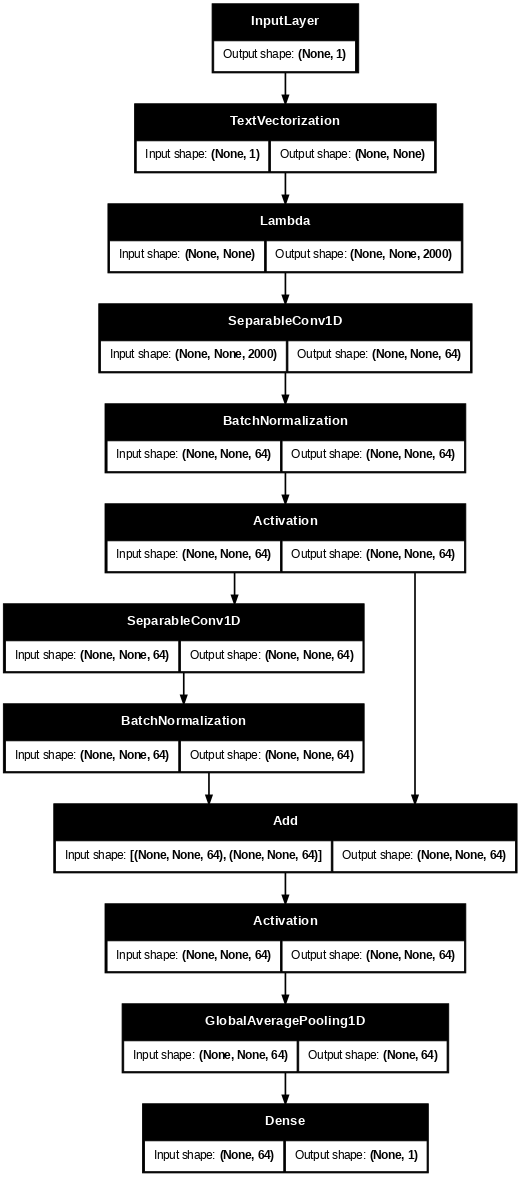

In [7]:
def build_model():
    inputs = keras.layers.Input(shape=(1,), dtype="string") # We take our strings as input
    processing = text_vectorization(inputs)
    one_hot = layers.Lambda(lambda x: tf.one_hot(x, depth=2000), output_shape=(None, 2000))(processing) # we one-hot encode those, so it becomes a length 2000 vector.

    # Define depth-wise separable convolutional layers with skip connections
    conv1 = layers.SeparableConv1D(filters=64, kernel_size=10, padding='same')(one_hot)
    bn1 = layers.BatchNormalization()(conv1)
    act1 = layers.Activation('relu')(bn1)

    conv2 = layers.SeparableConv1D(filters=64, kernel_size=10, padding='same')(act1)
    bn2 = layers.BatchNormalization()(conv2)
    skip1 = layers.Add()([act1, bn2])
    act2 = layers.Activation('relu')(skip1)

    # Define global pooling layer
    pool = layers.GlobalAveragePooling1D()(act2)

    # Define output layer for binary classification
    outputs = layers.Dense(units=1, activation='sigmoid')(pool)

    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model = build_model()

keras.utils.plot_model(model, show_shapes=True,dpi=60)
#print(model.summary())

Let's prepare our data split as we did previously...

In [8]:
data_train = trip_advisor_text[:1200]
labels_train = label[:1200]
data_test = trip_advisor_text[1200:]
labels_test = label[1200:]

And, let's fit the model (2-fold CV here, cause why not...)

In [9]:
k = 2
num_validation_samples = len(data_train) // k
num_epochs = 40
batch_sizes = 25
all_loss_histories = []
all_val_loss_histories = []
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history.
for fold in range(k):
    validation_data = data_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = labels_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        data_train[:num_validation_samples * fold],
        data_train[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        labels_train[:num_validation_samples * fold],
        labels_train[num_validation_samples * (fold + 1):]])
    model = build_model()
    history = model.fit(training_data, training_targets,
                        validation_data = (validation_data,validation_targets),
                        epochs=num_epochs, batch_size=batch_sizes)
    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.6721 - loss: 0.6232 - val_accuracy: 0.6667 - val_loss: 0.6773
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7772 - loss: 0.5114 - val_accuracy: 0.6667 - val_loss: 0.6723
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9321 - loss: 0.3579 - val_accuracy: 0.6667 - val_loss: 0.6674
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9725 - loss: 0.2306 - val_accuracy: 0.6667 - val_loss: 0.6627
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9819 - loss: 0.1591 - val_accuracy: 0.6667 - val_loss: 0.6592
Epoch 6/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9913 - loss: 0.1180 - val_accuracy: 0.6667 - val_loss: 0.6543
Epoch 7/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9913 - loss: 0.0895 - val_accuracy: 0.6683 - val_loss: 0.6476
Epoch 8/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9932 - loss: 0.0686 - val_accuracy: 0.6783 - 

Let's plot the performance in training...

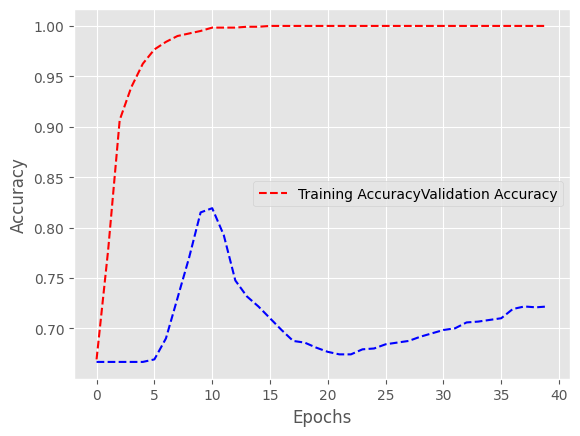

In [10]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Training Accuracy''Validation Accuracy'])
plt.show()

#*Model Using Bidirectional LSTM (Still No Embeddings, Yet)*

We will pass our integer sequences into a one-hot encoding layer, and from there into our Bidirectional LSTM.

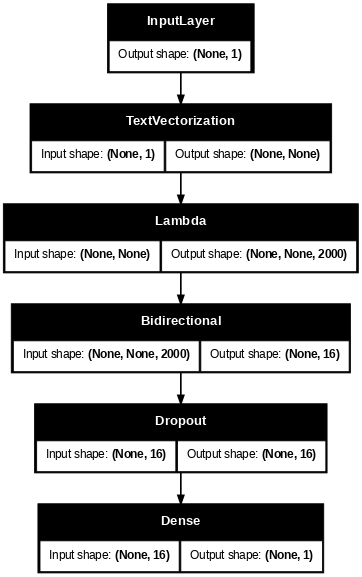

In [11]:
def build_model():
    inputs = keras.layers.Input(shape=(1,), dtype="string") # We take our strings as input
    processing = text_vectorization(inputs)
    one_hot = layers.Lambda(lambda x: tf.one_hot(x, depth=2000), output_shape=(None, 2000))(processing)
    x = layers.Bidirectional(layers.LSTM(8))(one_hot)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model = build_model()

keras.utils.plot_model(model, show_shapes=True,dpi=60)

Now we will fit our model with cross-validation again, as before...

In [12]:
k = 2
num_validation_samples = len(data_train) // k
num_epochs = 25
batch_sizes = 25
all_loss_histories = []
all_val_loss_histories = []
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history.
for fold in range(k):
    validation_data = data_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = labels_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        data_train[:num_validation_samples * fold],
        data_train[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        labels_train[:num_validation_samples * fold],
        labels_train[num_validation_samples * (fold + 1):]])
    model = build_model()
    history = model.fit(training_data, training_targets,
                        validation_data = (validation_data,validation_targets),
                        epochs=num_epochs, batch_size=batch_sizes)
    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6471 - loss: 0.6699 - val_accuracy: 0.6667 - val_loss: 0.6380
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6517 - loss: 0.6426 - val_accuracy: 0.6667 - val_loss: 0.6220
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6528 - loss: 0.5930 - val_accuracy: 0.6667 - val_loss: 0.6089
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7156 - loss: 0.5180 - val_accuracy: 0.7133 - val_loss: 0.6088
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8620 - loss: 0.4401 - val_accuracy: 0.6083 - val_loss: 0.6198
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9268 - loss: 0.4070 - val_accuracy: 0.5517 - val_loss: 0.6315
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9582 - loss: 0.3343 - val_accuracy: 0.5633 - val_loss: 0.6416
Epoch 8/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9483 - loss: 0.3267 - val_accuracy: 0.5667 - v

Finally, plot loss / accuracy over training... wow, this model peaks at about the 3rd epoch! It learns much faster than our old model did, though it gets to about the same level of performance.



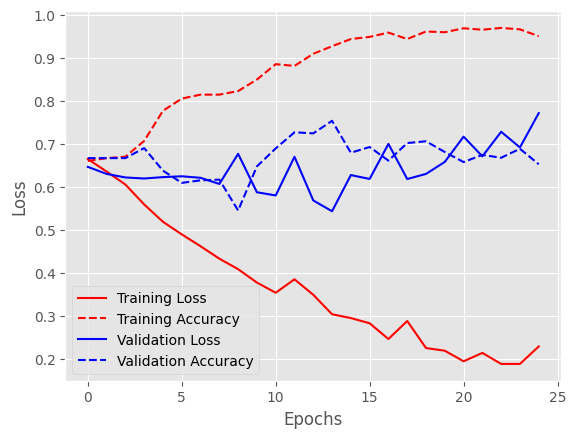

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

#*Textual Embeddings*

We can pre-process the text using an Embedding layer, before going to LSTM, to 'help the model along.' The Embedding layer will be of shape Vocabular-Size x Vector Length (dimensionality of the latent space). We can feed these sequences of vectors into our LSTM.

In [14]:
processing = text_vectorization(data_train)

In [15]:
print(processing)

tf.Tensor(
[[  11   48   12 ...    0    0    0]
 [   1    5  282 ...    0    0    0]
 [  23 1110    5 ...    0    0    0]
 ...
 [  67  805   38 ...    0    0    0]
 [   1    1   10 ...    0    0    0]
 [ 133   15    1 ...    0    0    0]], shape=(1200, 745), dtype=int64)


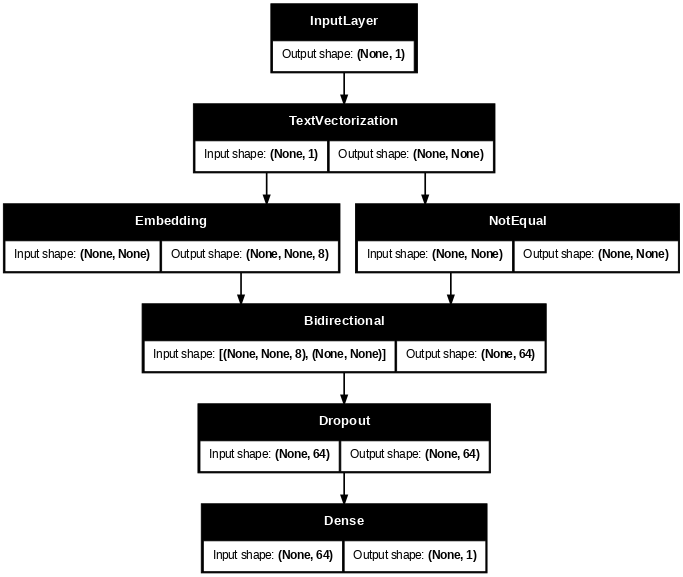

In [16]:
def build_model_embed():
    inputs = keras.layers.Input(shape=(1,), dtype="string") # We take our strings as input
    processing = text_vectorization(inputs)

    # Truncate after 600 tokens, and pad up to 600 tokens for shorter reviews (we already padded, so matters little)).
    # Mask zero means it will yield a boolean mask tensor for the LSTM that tells it to ignore any zeroes.
    embedding = keras.layers.Embedding(input_dim=2000,output_dim=8,mask_zero=True)(processing)

    x = keras.layers.Bidirectional(keras.layers.LSTM(32))(embedding)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model_embed = build_model_embed()

keras.utils.plot_model(model_embed, show_shapes=True, dpi=60)

Fit the model again...

In [17]:
k = 2
num_validation_samples = len(data_train) // k
num_epochs = 25
batch_sizes = 25
all_loss_histories = []
all_val_loss_histories = []
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history.
for fold in range(k):
    validation_data = data_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = labels_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        data_train[:num_validation_samples * fold],
        data_train[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        labels_train[:num_validation_samples * fold],
        labels_train[num_validation_samples * (fold + 1):]])
    model = build_model_embed()
    history = model.fit(training_data, training_targets,
                        validation_data = (validation_data,validation_targets),
                        epochs=num_epochs, batch_size=batch_sizes)
    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.6517 - loss: 0.6724 - val_accuracy: 0.6667 - val_loss: 0.6366
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6517 - loss: 0.6405 - val_accuracy: 0.6667 - val_loss: 0.6275
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6517 - loss: 0.6116 - val_accuracy: 0.6667 - val_loss: 0.5963
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7399 - loss: 0.4687 - val_accuracy: 0.5750 - val_loss: 0.6628
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9087 - loss: 0.2536 - val_accuracy: 0.5133 - val_loss: 0.9767
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9362 - loss: 0.2067 - val_accuracy: 0.6500 - val_loss: 0.8521
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9544 - loss: 0.1534 - val_accuracy: 0.6983 - val_loss: 0.6860
Epoch 8/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9604 - loss: 0.1135 - val_accuracy: 0.7017 - v

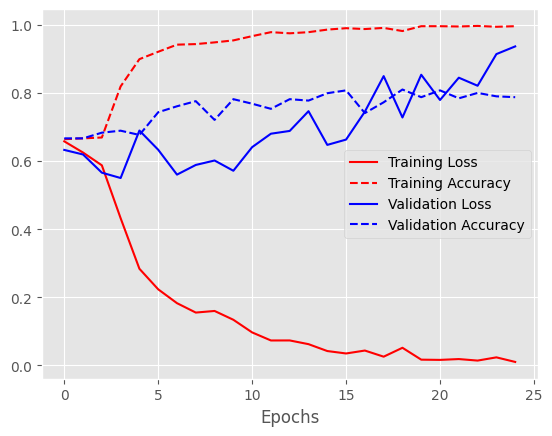

In [18]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

#*Word2Vec Embeddings*

Now we will try out the word2vec pre-trained embeddings (from Wikipedia). Let's download the English language, Wikipedia 100-dimensional embeddings. Note that this can take some time because the embedding file is large.

In [19]:
!wget http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.pkl.bz2
!bzip2 -d enwiki_20180420_100d.pkl.bz2

--2025-04-08 00:08:07--  http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.pkl.bz2
Resolving wikipedia2vec.s3.amazonaws.com (wikipedia2vec.s3.amazonaws.com)... 52.219.200.13, 3.5.156.91, 52.219.150.57, ...
Connecting to wikipedia2vec.s3.amazonaws.com (wikipedia2vec.s3.amazonaws.com)|52.219.200.13|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3514838671 (3.3G) [application/x-bzip2]
Saving to: ‘enwiki_20180420_100d.pkl.bz2’

enwiki_20180420_100 100%[===================>]   3.27G  30.4MB/s    in 2m 1s   

2025-04-08 00:10:09 (27.6 MB/s) - ‘enwiki_20180420_100d.pkl.bz2’ saved [3514838671/3514838671]



Now let's create an embedding matrix, as before, etc. Note, we can see that most of the words for which we lack embeddings are actually typos or proper nouns. We could manually fix the typos, or not (perhaps the typos are indicative of deceipt!

In [20]:
try:
  from wikipedia2vec import Wikipedia2Vec
except ImportError as error:
  !pip install wikipedia2vec
  from wikipedia2vec import Wikipedia2Vec

from wikipedia2vec import Wikipedia2Vec

# These embeddings are 100 dimensional also.
embedding_dim = 100

wiki2vec = Wikipedia2Vec.load('enwiki_20180420_100d.pkl')

vocabulary = text_vectorization.get_vocabulary() # From the vocabulary our text vectorizer learned from our dataset, go over every word.
word_index = dict(zip(vocabulary, range(len(vocabulary)))) # Make a dictionary, key is word to value is index.
embedding_matrix = np.zeros((len(vocabulary), embedding_dim))

for word, index in word_index.items():
    try:
        embedding_matrix[index] = wiki2vec.get_word_vector(f'{word}')
    except:
        print(f'Skipping {word}, no embedding for it.')
        continue

print(f'The embedding for \'room\' is {embedding_matrix[15]}.')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.8/297.8 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.3/196.3 kB 24.9 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[-0.12560804 -0.5235532  -0.13231167 ... -0.48633438  0.45111445
   0.11309847]
 [-0.12473089 -0.6455471   0.13622157 ... -0.6347396   0.5410465
   0.32159257]
 [-0.05129661 -0.4987064  -0.09563554 ... -0.30148467  0.24280211
  -0.08308805]
 ...
 [-1.0583687  -0.83086014 -0.4427682  ... -1.0160557  -0.02469787
   0.99688977]
 [-1.0772408  -0.32139003 -0.79673034 ... -1.3150353  -0.12155519
   0.57841384]
 [-0.86319923 -0.5425662  -0.5506818  ... -1.1069874   0.26995388
   0.43403685]] loaded from the file enwiki_20180420_100d.pkl is not byte aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/joblib/numpy_pickle.py:230

Skipping , no embedding for it.
Skipping [UNK], no embedding for it.
Skipping werent, no embedding for it.
Skipping inroom, no embedding for it.
Skipping hadnt, no embedding for it.
Skipping definately, no embedding for it.
Skipping shouldnt, no embedding for it.
Skipping accomodating, no embedding for it.
Skipping ohare, no embedding for it.
Skipping accomodations, no embedding for it.
Skipping definetly, no embedding for it.
Skipping shulas, no embedding for it.
The embedding for 'room' is [-0.04475478  0.52349627  0.15551241  0.13616104  0.00284019 -0.08661265
  0.05645907 -0.20347282  0.02514262 -0.50536108 -0.38650605 -0.0852759
  0.29945976 -0.11940839 -0.06857705 -0.17449841  0.2246068   0.13887054
  0.15167743  0.17579257  0.04217658 -0.10980772  0.09993367  0.01266596
 -0.20744962 -0.50846672  0.27036953 -0.18056074 -0.01523099  0.32400358
  0.19859086 -0.16741541 -0.17544943 -0.2759535  -0.40312016 -0.3360047
 -0.26442048 -0.25339603  0.28910047 -0.36898452  0.09097765 -0.053

And, again, let's make our embedding layer...

In [21]:
embedding_layer = layers.Embedding(
    len(vocabulary), # 2000 words.
    100, # Vectors of 100 elements per word.
    embeddings_initializer=keras.initializers.Constant(embedding_matrix), # Initialize with fixed values from our matrix.
    trainable=False, # These are weights, but they will be frozen so they don't update during training.
    mask_zero=True, # If we have a 0 token, for padding, we don't pass it through the layer.
)

And we instantiate the model again...

In [40]:
def build_model_word2vec():
    inputs = keras.layers.Input(shape=(1,), dtype="string") # We take our strings as input
    processing = text_vectorization(inputs)

    embedding = embedding_layer(processing)

    x = keras.layers.BatchNormalization()(embedding)
    x = keras.layers.Bidirectional(keras.layers.LSTM(32,return_sequences=True))(x)
    x = keras.layers.Bidirectional(keras.layers.LSTM(32))(embedding)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

And, let's fit the model one last time... once again, these don't help! The embeddings actually hurt.

In [41]:
model = build_model_word2vec()
history = model.fit(trip_advisor_text, label, validation_split=0.2,
                    epochs=10, batch_size=16)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.6029 - loss: 0.6632 - val_accuracy: 0.1562 - val_loss: 0.8831
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7121 - loss: 0.5680 - val_accuracy: 0.6531 - val_loss: 0.6447
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7907 - loss: 0.4831 - val_accuracy: 0.6313 - val_loss: 0.7296
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8053 - loss: 0.4359 - val_accuracy: 0.6438 - val_loss: 0.7106
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7985 - loss: 0.4220 - val_accuracy: 0.6719 - val_loss: 0.6992
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8209 - loss: 0.3945 - val_accuracy: 0.6281 - val_loss: 0.7258
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8340 - loss: 0.3783 - val_accuracy: 0.5063 - val_loss: 1.0031
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8536 - loss: 0.3608 - val_accuracy: 0.6625 - v

Plotting average model loss / accuracy across folds, over training.

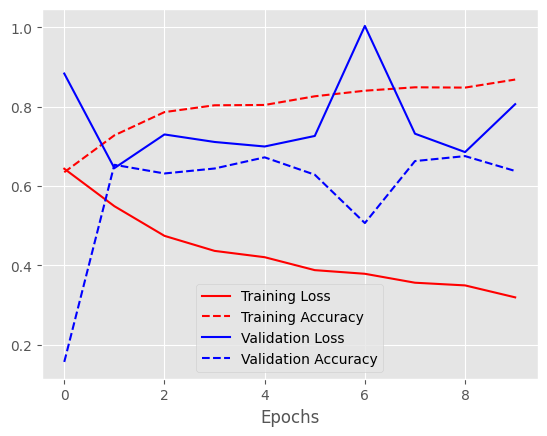

In [42]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(history.history['loss'],c='r')
plt.plot(history.history['accuracy'],c="r",linestyle="dashed")
plt.plot(history.history['val_loss'],c='b')
plt.plot(history.history['val_accuracy'],c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()